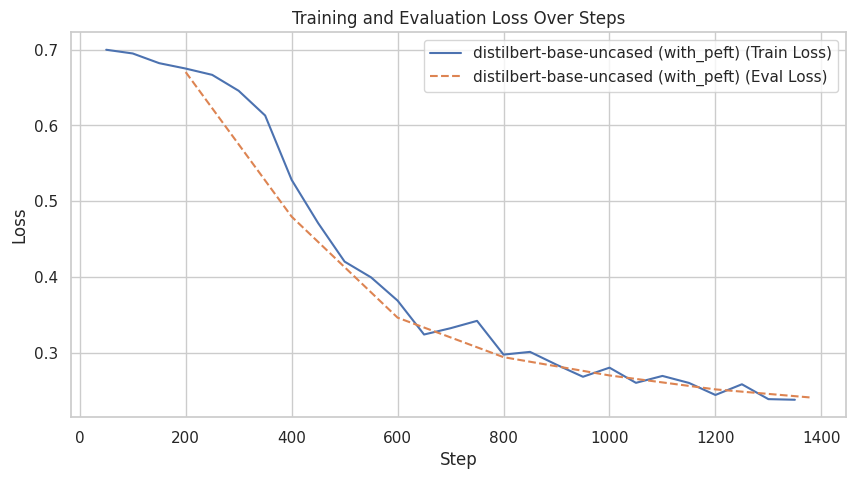

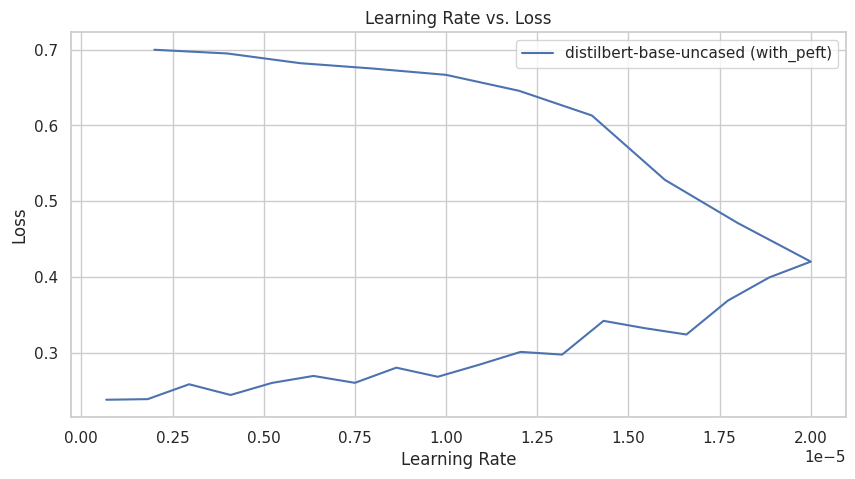

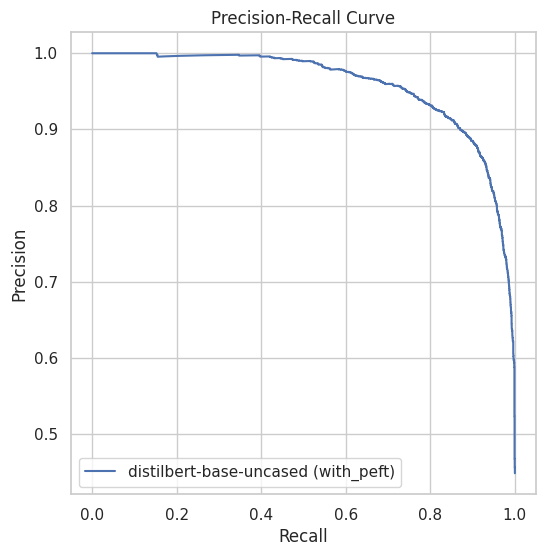

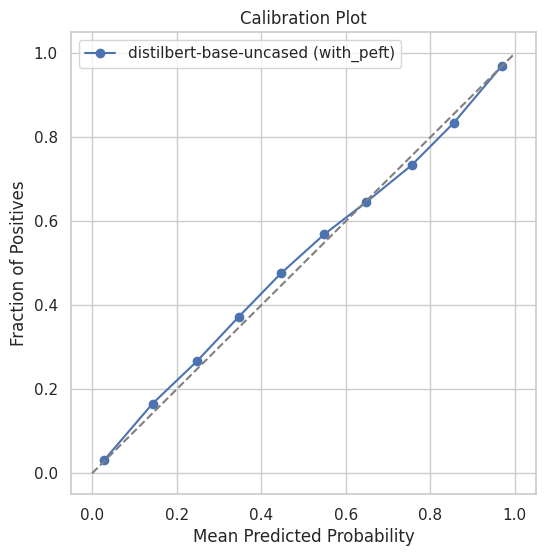

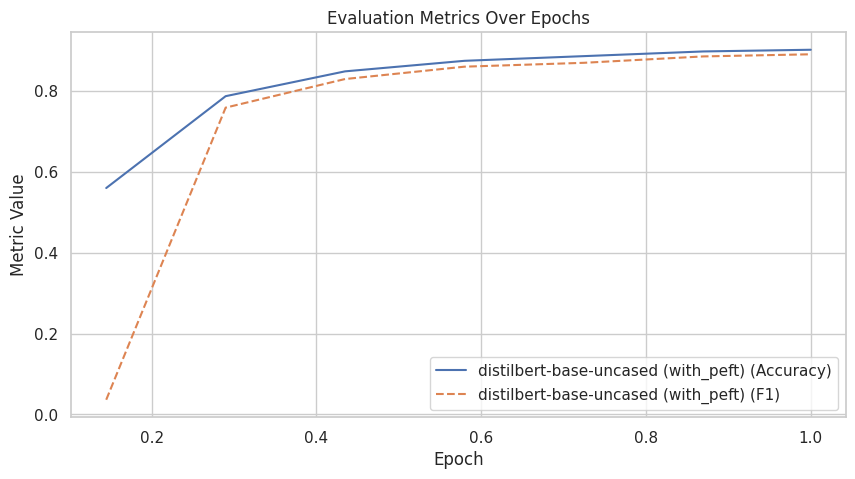

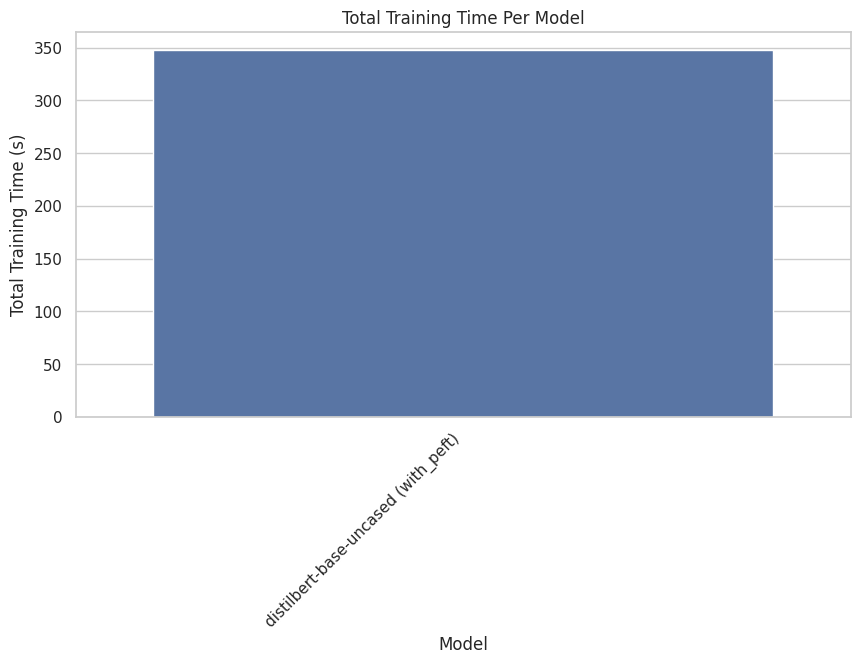

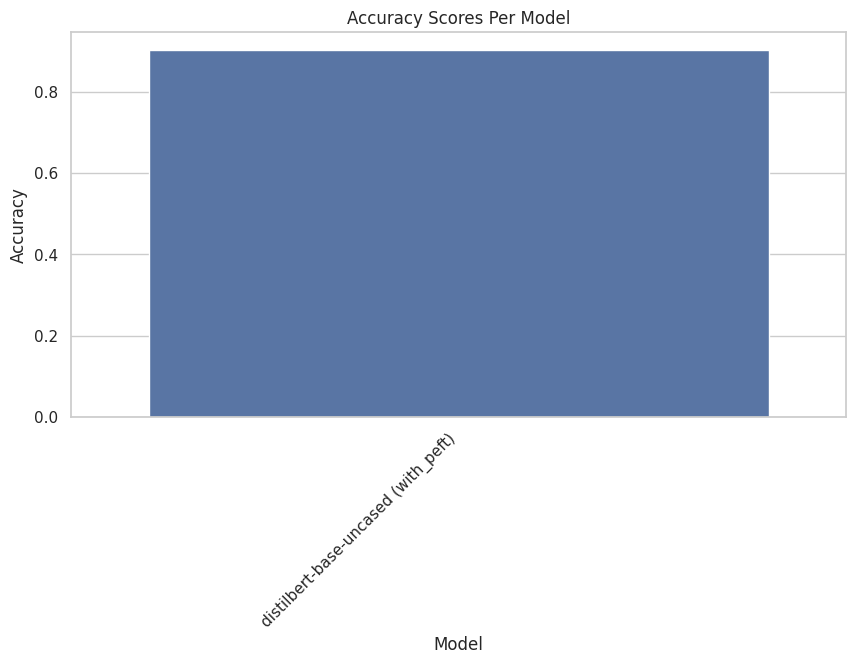

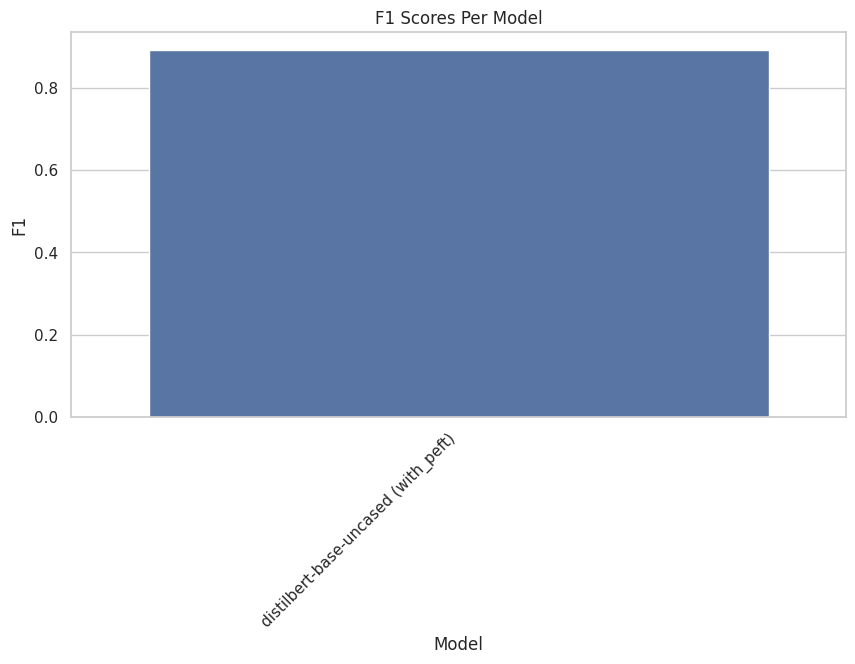

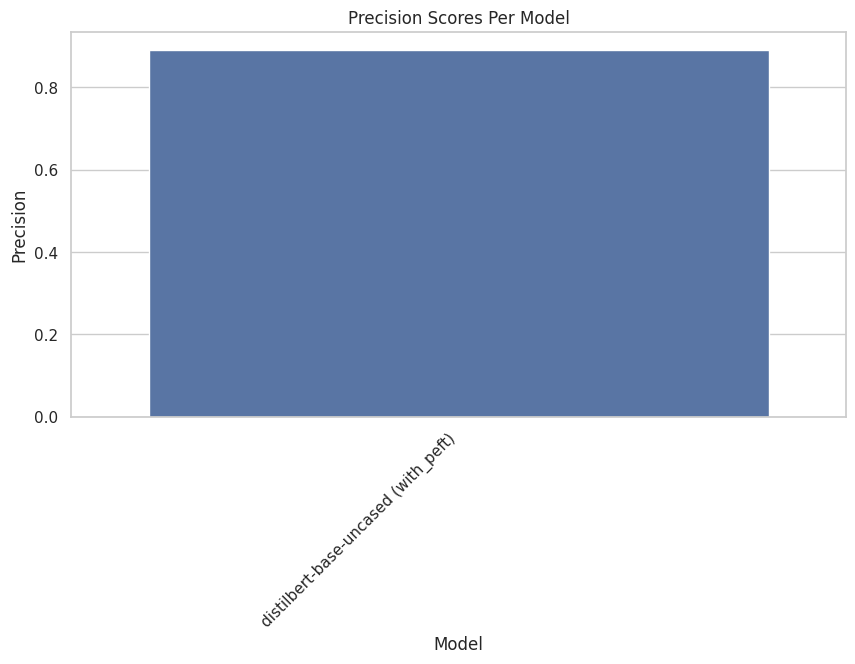

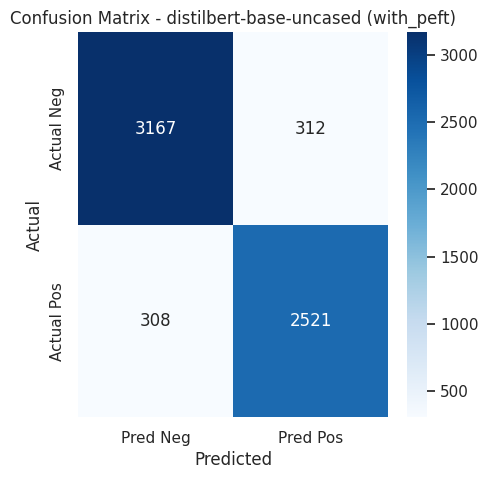

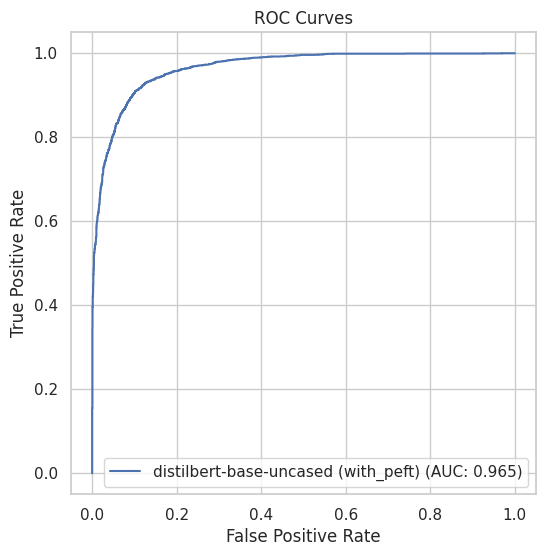

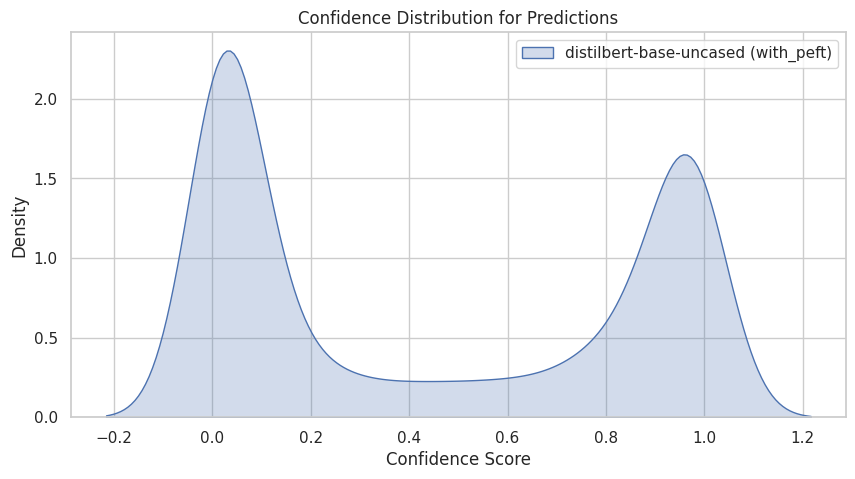

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve

def load_model_results(base_path):
    data = {}
    for peft_type in ["with_peft", "without_peft"]:
        peft_path = os.path.join(base_path, peft_type)
        if not os.path.exists(peft_path):
            continue
        
        for model_name in os.listdir(peft_path):
            model_path = os.path.join(peft_path, model_name)
            if not os.path.isdir(model_path):
                continue
            
            model_key = f"{model_name} ({peft_type})"
            data[model_key] = {}
            
            for file in glob.glob(os.path.join(model_path, "*.parquet")):
                file_key = os.path.basename(file).replace(".parquet", "")
                data[model_key][file_key] = pd.read_parquet(file)
    
    return data

def visualize_results(data):
    sns.set(style="whitegrid")
    
    # Training and Evaluation Loss Over Steps
    plt.figure(figsize=(10, 5))
    for model, files in data.items():
        if "training_logs" in files:
            df = files["training_logs"]
            plt.plot(df["step"], df["loss"], label=f"{model} (Train Loss)")
        if "eval_logs" in files:
            df = files["eval_logs"]
            plt.plot(df["step"], df["loss"], linestyle="dashed", label=f"{model} (Eval Loss)")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Over Steps")
    plt.legend()
    plt.show()
    
    # Learning Rate vs. Loss
    plt.figure(figsize=(10, 5))
    for model, files in data.items():
        if "training_logs" in files:
            df = files["training_logs"]
            plt.plot(df["learning_rate"], df["loss"], label=f"{model}")
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.title("Learning Rate vs. Loss")
    plt.legend()
    plt.show()
    
    # Precision-Recall Curve
    plt.figure(figsize=(6, 6))
    for model, files in data.items():
        if "sklearn_predictions" in files:
            df = files["sklearn_predictions"]
            precision, recall, _ = precision_recall_curve(df["true_label"], df["confidence_positive"])
            plt.plot(recall, precision, label=f"{model}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()
    
    # Calibration Plot
    plt.figure(figsize=(6, 6))
    for model, files in data.items():
        if "sklearn_predictions" in files:
            df = files["sklearn_predictions"]
            prob_true, prob_pred = calibration_curve(df["true_label"], df["confidence_positive"], n_bins=10)
            plt.plot(prob_pred, prob_true, marker="o", label=f"{model}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Plot")
    plt.legend()
    plt.show()
    
    # Evaluation Metrics Over Epochs
    plt.figure(figsize=(10, 5))
    for model, files in data.items():
        if "eval_logs" in files:
            df = files["eval_logs"]
            plt.plot(df["epoch"], df["accuracy"], label=f"{model} (Accuracy)")
            plt.plot(df["epoch"], df["f1"], linestyle="dashed", label=f"{model} (F1)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.title("Evaluation Metrics Over Epochs")
    plt.legend()
    plt.show()
    
    # Training Time Per Model
    plt.figure(figsize=(10, 5))
    times = {model: files["eval_logs"]["runtime"].sum() for model, files in data.items() if "eval_logs" in files}
    sns.barplot(x=list(times.keys()), y=list(times.values()))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Model")
    plt.ylabel("Total Training Time (s)")
    plt.title("Total Training Time Per Model")
    plt.show()
    
    # Bar Plots for F1, Accuracy, Precision
    metrics = ["accuracy", "f1", "precision"]
    for metric in metrics:
        plt.figure(figsize=(10, 5))
        values = {model: files["sklearn_metrics"][metric].iloc[0] for model, files in data.items() if "sklearn_metrics" in files}
        sns.barplot(x=list(values.keys()), y=list(values.values()))
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Model")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} Scores Per Model")
        plt.show()
    
    # Confusion Matrix Heatmap
    for model, files in data.items():
        if "sklearn_confusion" in files:
            df = files["sklearn_confusion"]
            cm = df.iloc[:, 1:].values.reshape(2, 2)  # Extracting values
            plt.figure(figsize=(5, 5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Neg", "Pred Pos"], yticklabels=["Actual Neg", "Actual Pos"])
            plt.title(f"Confusion Matrix - {model}")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()
    
    # ROC Curve
    plt.figure(figsize=(6, 6))
    for model, files in data.items():
        if "sklearn_roc" in files:
            df = files["sklearn_roc"]
            plt.plot(df["false_positive_rate"], df["true_positive_rate"], label=f"{model} (AUC: {df['auc'].iloc[0]:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()
    
    # Predictions Confidence Distribution
    plt.figure(figsize=(10, 5))
    for model, files in data.items():
        if "sklearn_predictions" in files:
            df = files["sklearn_predictions"]
            sns.kdeplot(df["confidence_positive"], label=model, fill=True)
    plt.xlabel("Confidence Score")
    plt.ylabel("Density")
    plt.title("Confidence Distribution for Predictions")
    plt.legend()
    plt.show()



data = load_model_results("/home/nikl/programming/fhdw/knowledge_engineering_ausarbeitung/fakenews_detection/data/model_evaluation")
visualize_results(data)


In [24]:
print(data["distilbert-base-uncased (with_peft)"].keys())
display(data["distilbert-base-uncased (with_peft)"]["summary_logs"])
display(data["distilbert-base-uncased (with_peft)"]["eval_logs"])
display(data["distilbert-base-uncased (with_peft)"]["training_logs"])

dict_keys(['summary_logs', 'sklearn_roc', 'sklearn_confusion', 'training_logs', 'sklearn_metrics', 'sklearn_predictions', 'eval_logs'])


,epoch,step,total_flos,train_loss,train_runtime,train_samples_per_second,train_steps_per_second
0,1.0,1380,5.989150e+15,0.406191,795.2602,55.52,1.735


,epoch,step,loss,accuracy,f1,precision,recall,runtime,samples_per_second,steps_per_second,loss_change,best_loss_so_far,best_accuracy_so_far
0,0.144928,200,0.670359,0.559845,0.036439,0.990566,0.018561,52.5365,240.138,7.519,NaN,0.670359,0.559845
1,0.289855,400,0.479799,0.786937,0.758621,0.770944,0.746686,53.6716,235.059,7.360,-0.190560,0.479799,0.786937
2,0.434783,600,0.346627,0.848288,0.829320,0.836782,0.821990,54.5340,231.342,7.243,-0.133172,0.346627,0.848288
3,0.579710,800,0.294552,0.874366,0.859871,0.860099,0.859643,54.5366,231.331,7.243,-0.052076,0.294552,0.874366
4,0.724638,1000,0.270455,0.885938,0.869431,0.893177,0.846915,51.2426,246.201,7.708,-0.024096,0.270455,0.885938
5,0.869565,1200,0.252062,0.897511,0.885220,0.889087,0.881386,54.7303,230.512,7.217,-0.018394,0.252062,0.897511
6,1.000000,1380,0.241354,0.901712,0.890498,0.889869,0.891128,26.2179,240.599,7.552,-0.010708,0.241354,0.901712


,loss,grad_norm,learning_rate,epoch,step,loss_change,loss_change_rate
0,0.6998,0.514249,2.000000e-06,0.036232,50,NaN,NaN
1,0.6949,2.319886,4.000000e-06,0.072464,100,-0.0049,-0.007002
2,0.6821,1.527125,6.000000e-06,0.108696,150,-0.0128,-0.018420
3,0.6750,0.777563,8.000000e-06,0.144928,200,-0.0071,-0.010409
4,0.6667,0.795110,1.000000e-05,0.181159,250,-0.0083,-0.012296
5,0.6457,1.294731,1.200000e-05,0.217391,300,-0.0210,-0.031498
6,0.6131,0.834836,1.400000e-05,0.253623,350,-0.0326,-0.050488
7,0.5283,1.797730,1.600000e-05,0.289855,400,-0.0848,-0.138313
8,0.4713,1.514829,1.800000e-05,0.326087,450,-0.0570,-0.107893
9,0.4205,1.832684,2.000000e-05,0.362319,500,-0.0508,-0.107787
